In [1]:
import numpy as np
import pandas as pd
import os, sys, pickle

from collections import defaultdict
import networkx as nx
from copy import deepcopy
from operator import itemgetter 

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim

os.chdir('/content/drive/MyDrive/yeonjun/공부/RecSys/intro_to_recsys/paper_review/5. Random Walk based/')
from utils import make_graph_data, SamplingAliasMethod

from datetime import datetime
import matplotlib.pyplot as plt

import os, random, warnings, math
warnings.filterwarnings('ignore')


In [2]:
graph = make_graph_data('../../data/ind.citeseer.graph', weighted=True, num_type_node=False)

In [4]:
class Config:
    learning_rate_f = 0.005
    learning_rate_s = 0.01
    epoch_f = 200
    epoch_s = 30
    epochs = max(epoch_f, epoch_s)

    weight_decay = 0.01
    seed = 1995
    embed_dim = 30
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 128
    neg_sampling_per_pos = 5
    num_batch_per_epoch = graph.number_of_edges() // batch_size
    order = 'all'

config = Config()

In [10]:
class Dataset:
    def __init__(self, graph, batch_size, neg_sampling_per_pos):
        self.graph = graph
        self.neg_sampling_per_pos = neg_sampling_per_pos
        self.edge_info, self.node_info = self.get_graph_info(graph)
        self.node_sampler = SamplingAliasMethod(self.node_info[1])
        self.edge_sampler = SamplingAliasMethod(self.edge_info[1])
        
        self.edge_num = len(self.edge_info[0])
        self.node_num = len(self.node_info[0])

        self.batch_size = batch_size
        self.edge_w = np.array(self.edge_info[1]) / np.sum(self.edge_info[1])
    
    def get_graph_info(self, graph):
        edge_idx, edge_weight = [], []
        node_degree = defaultdict(int)
        
        for edge in self.graph.edges():
            src = edge[0]
            dst = edge[1]

            edge_idx.append(edge)
            edge_weight.append(self.graph[src][dst]['weight'])

            node_degree[src] += self.graph[src][dst]['weight']

        node_idx, node_weight = np.arange(graph.number_of_nodes()), np.zeros(graph.number_of_nodes())
        for n, d in node_degree.items():
            node_weight[n] = np.power(d, 3/4)

        return (edge_idx, edge_weight), (node_idx, node_weight)
    
    # def get_graph_info(self, graph):
    #     edge_idx, edge_weight = [], []
    #     node_degree = defaultdict(int)
        
    #     for edge in self.graph.edges():
    #         src = edge[0]
    #         dst = edge[1]

    #         edge_idx.append(edge)
    #         edge_weight.append(self.graph[src][dst]['weight'])

    #         node_degree[src] += self.graph[src][dst]['weight']

    #     node_idx, node_weight = [], []
    #     for n, d in node_degree.items():
    #         node_idx.append(n)
    #         node_weight.append(np.power(n, 3/4))

    #     return (edge_idx, edge_weight), (node_idx, node_weight)
    
    def get_batch(self,):
        # positive edge sampling
        sampled_edge_idx = self.edge_sampler.return_sample(self.batch_size)
        # for _ in range(self.edge_num // self.batch_size + 1):
        pos = [self.edge_info[0][a] for a in sampled_edge_idx] 
        pos_weight = [self.edge_w[a] for a in sampled_edge_idx] 
        # negative edge sampling
        neg= []
        for i, s in enumerate(pos):
            src = s[0]
            neg_sampled = self.node_sampler.return_sample(self.neg_sampling_per_pos)
            neg_edges = [(src, self.node_info[0][a]) for a in neg_sampled]
            neg.extend(neg_edges)
        
        return {'pos':torch.tensor(pos, dtype=torch.long).to(config.device),
                'pos_w':torch.tensor(pos_weight, dtype=torch.float).to(config.device),
                'neg':torch.tensor(neg, dtype=torch.long).to(config.device),
                }

In [11]:
class LINE(nn.Module):
    def __init__(self, order, K_neg, small_d, n_node, device):
        super(LINE, self).__init__()
        
        self.order = order

        if order == 'first':
            self.embed_1 = nn.Embedding(n_node, small_d)
        elif order == 'second':
            self.embed_2 = nn.Embedding(n_node, small_d)
            self.embed_2_context = nn.Embedding(n_node, small_d)
        else:
            self.embed_1 = nn.Embedding(n_node, small_d)
            self.embed_2 = nn.Embedding(n_node, small_d)
            self.embed_2_context = nn.Embedding(n_node, small_d)

    def forward(self, batch_data):
        pos_edge = batch_data['pos']
        pos_edge_w = batch_data['pos_w']
        neg_edge = batch_data['neg']
        pos_src, pos_dst = pos_edge[:, 0], pos_edge[:, 1]
        neg_src, neg_dst = neg_edge[:, 0], neg_edge[:, 1]

        if self.order == 'first':
            return {'first':self.first_loss(pos_src, pos_dst, pos_edge_w), 'second':0}
        
        if self.order == 'second':
            return {'second':self.second_loss(pos_src, pos_dst, neg_src, neg_dst), 'first':0}

        if self.order == 'all':
            return {
                'first':self.first_loss(pos_src, pos_dst, pos_edge_w),
                'second':self.second_loss(pos_src, pos_dst, neg_src, neg_dst)
            }
    
    def first_loss(self, pos_src, pos_dst, pos_edge_w):
        ui = self.embed_1(pos_src)
        uj = self.embed_1(pos_dst)
        pvivj = torch.sigmoid(torch.sum(ui * uj, axis=1))
        loss = -torch.sum(pos_edge_w * torch.log(pvivj))
        return loss
    
    def second_loss(self, pos_src, pos_dst, neg_src, neg_dst):
        ui = self.embed_2(pos_src)
        ujp = self.embed_2_context(pos_dst)
        pos_loss = torch.sum(torch.log(torch.sigmoid(torch.sum(ui * ujp, axis=1))))
        
        ui = self.embed_2(neg_src)
        ujp = self.embed_2_context(neg_dst)
        neg_loss = torch.sum(torch.log(torch.sigmoid(-torch.sum(ui * ujp, axis=1))))
        return -(pos_loss + neg_loss)
    
    def get_embeddings(self, node_idx):
        '''
        node_idx => torch.longtensor
        '''
        if self.order == 'first':
            return self.embed_1(node_idx)    
        if self.order == 'second':
            return self.embed_2(node_idx)  
        if self.order == 'all':
            return torch.cat([self.embed_1(node_idx), self.embed_2(node_idx)], axis=1)

In [12]:
def get_params_group(model, type):
    if type == 'first':
        optimizer_parameters = [{'params': [p for n,p in model.named_parameters() if 'embed_1' in n]}]
    if type == 'second':
        optimizer_parameters = [{'params': [p for n,p in model.named_parameters() if 'embed_2' in n]}]
    return optimizer_parameters

In [13]:
dataset = Dataset(graph, batch_size=config.batch_size, neg_sampling_per_pos=config.neg_sampling_per_pos)
model = LINE(order=config.order, K_neg=5, small_d=30, n_node=graph.number_of_nodes(), device='cuda')
model = model.to('cuda')

optimizer_f = optim.SGD(get_params_group(model, 'first'), lr=config.learning_rate_f, momentum=0.9)   
optimizer_s = optim.SGD(get_params_group(model, 'second'), lr=config.learning_rate_s, momentum=0.9)

start = datetime.now()
history_f, history_s = defaultdict(list), defaultdict(list)
for epoch in range(config.epochs):
    model.train()
    losses_f, losses_s = [], []
    for _ in range(config.num_batch_per_epoch):
        batch_data = dataset.get_batch()
        
        optimizer_f.zero_grad()
        optimizer_s.zero_grad()
        
        losses = model(batch_data)
        if (config.order == 'first' or config.order == 'all') and config.epoch_f >= epoch+1:
            loss_f = losses['first']
            loss_f.backward()
            optimizer_f.step()
            losses_f.append(loss_f.item())
        
        if (config.order == 'second' or config.order == 'all') and config.epoch_s >= epoch+1:
            loss_s = losses['second']
            losses_s.append(loss_s.item())    
            loss_s.backward()
            optimizer_s.step()
        
    display_f = f'Training ended at epoch {config.epoch_f}' if np.isnan(np.mean(losses_f)) else np.round(np.mean(losses_f), 6)
    display_s = f'Training ended at epoch {config.epoch_s}' if np.isnan(np.mean(losses_s)) else np.round(np.mean(losses_s), 6)

    history_f[epoch] = np.mean(losses_f)
    history_s[epoch] = np.mean(losses_s)

    if epoch == 0 or (epoch+1) % 10 == 0:
        print(f'EPOCH {epoch+1} TRAIN First Loss : {display_f}, TRAIN Second Loss : {display_s}')


EPOCH 1 TRAIN First Loss : 0.082919, TRAIN Second Loss : 1562.842801
EPOCH 10 TRAIN First Loss : 0.081914, TRAIN Second Loss : 154.863053
EPOCH 20 TRAIN First Loss : 0.077779, TRAIN Second Loss : 42.376134
EPOCH 30 TRAIN First Loss : 0.080097, TRAIN Second Loss : 25.86897
EPOCH 40 TRAIN First Loss : 0.082989, TRAIN Second Loss : Training ended at epoch 30
EPOCH 50 TRAIN First Loss : 0.079397, TRAIN Second Loss : Training ended at epoch 30
EPOCH 60 TRAIN First Loss : 0.076701, TRAIN Second Loss : Training ended at epoch 30
EPOCH 70 TRAIN First Loss : 0.077506, TRAIN Second Loss : Training ended at epoch 30
EPOCH 80 TRAIN First Loss : 0.077939, TRAIN Second Loss : Training ended at epoch 30
EPOCH 90 TRAIN First Loss : 0.07449, TRAIN Second Loss : Training ended at epoch 30
EPOCH 100 TRAIN First Loss : 0.079482, TRAIN Second Loss : Training ended at epoch 30
EPOCH 110 TRAIN First Loss : 0.077976, TRAIN Second Loss : Training ended at epoch 30
EPOCH 120 TRAIN First Loss : 0.078129, TRAIN S

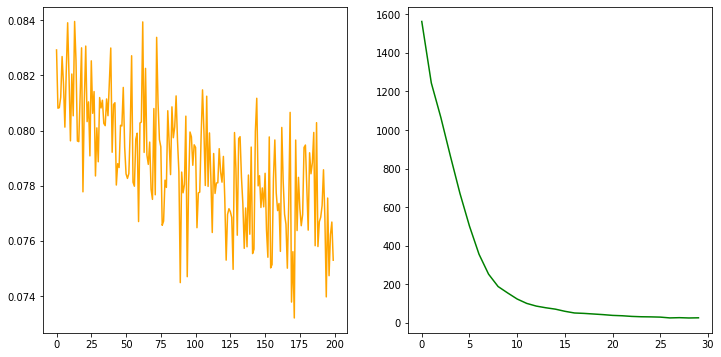

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
axes[0].plot(list(history_f.keys()), list(history_f.values()), color='orange')
axes[1].plot(list(history_s.keys()), list(history_s.values()), color='green')

In [15]:
node_want_embed = torch.LongTensor([0, 1, 2, 3]).to(config.device)

model.get_embeddings(node_want_embed).shape

torch.Size([4, 60])